### Import modules

In [38]:
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import os
import matplotlib.pyplot as plt
import numpy as np

### Connect Data Base & Load Tables

In [2]:
database = os.getenv('BikeSharing_DB')
username = os.getenv('BikeSharing_User')
password = os.getenv('BikeSharing_Pass')
host = os.getenv('BikeSharing_Host')
port = os.getenv('BikeSharing_Port')

try:
    connection_string = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"
    engine = create_engine(connection_string)

except Exception as e:
    print(f"Connecting error: {e}")


In [3]:
query = "SELECT * FROM rides_2022"
df_rides = pd.read_sql(query, connection_string)

query = "SELECT * FROM dim_rideable_type"
df_rideable_type = pd.read_sql(query, connection_string)

query = "SELECT * FROM dim_station"
df_station = pd.read_sql(query, connection_string)

query = "SELECT * FROM dim_user_type"
df_user_type = pd.read_sql(query, connection_string)


### EDA

In [4]:
#Integrety check
df_rides.isnull().sum()

ride_id                  0
rideable_id              0
started_at               0
ended_at                 0
start_station_id    833064
end_station_id      892742
start_lat                0
start_lng                0
end_lat               5858
end_lng               5858
user_type_id             0
dtype: int64

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_rides.describe()

,rideable_id,start_lat,start_lng,end_lat,end_lng,user_type_id
count,5667717.00,5667717.00,5667717.00,5661859.00,5661859.00,5667717.00
mean,1.52,41.90,-87.65,41.90,-87.65,1.59
std,0.56,0.05,0.03,0.07,0.11,0.49
min,1.00,41.64,-87.84,0.00,-88.14,1.00
25%,1.00,41.88,-87.66,41.88,-87.66,1.00
50%,1.00,41.90,-87.64,41.90,-87.64,2.00
75%,2.00,41.93,-87.63,41.93,-87.63,2.00
max,3.00,45.64,-73.80,42.37,0.00,2.00


### Create duration column

In [6]:
# Convert 'started_at' and 'ended_at' to datetime if they are not already
df_rides['started_at'] = pd.to_datetime(df_rides['started_at'])
df_rides['ended_at'] = pd.to_datetime(df_rides['ended_at'])

# Calculate trip duration
df_rides['duration'] = df_rides['ended_at'] - df_rides['started_at']



In [7]:
df_rides['duration'].describe()

count                      5667717
mean     0 days 00:19:26.597144670
std      0 days 02:56:07.687857087
min              -8 days +19:26:39
25%                0 days 00:05:49
50%                0 days 00:10:17
75%                0 days 00:18:28
max               28 days 17:47:15
Name: duration, dtype: object

### Duration

In [8]:

# Convert 'started_at' y 'ended_at' to datetime 
df_rides['started_at'] = pd.to_datetime(df_rides['started_at'])
df_rides['ended_at'] = pd.to_datetime(df_rides['ended_at'])

# Calculate ride duration
df_rides['duration'] = df_rides['ended_at'] - df_rides['started_at']

# Filter records with durationes lower than 0
df_rides_filtered = df_rides[df_rides['duration'] > pd.Timedelta(0)]



In [9]:
# Verify that all durations are greater than 0
assert (df_rides_filtered['duration'] > pd.Timedelta(0)).all(), "There are negative or duration with 00:00:00 in the df."

print(df_rides_filtered['duration'].describe(), "All durations are positive and greater than 0.")


count                      5667186
mean     0 days 00:19:26.845749901
std      0 days 02:56:04.932799822
min                0 days 00:00:01
25%                0 days 00:05:49
50%                0 days 00:10:17
75%                0 days 00:18:28
max               28 days 17:47:15
Name: duration, dtype: object All durations are positive and greater than 0.


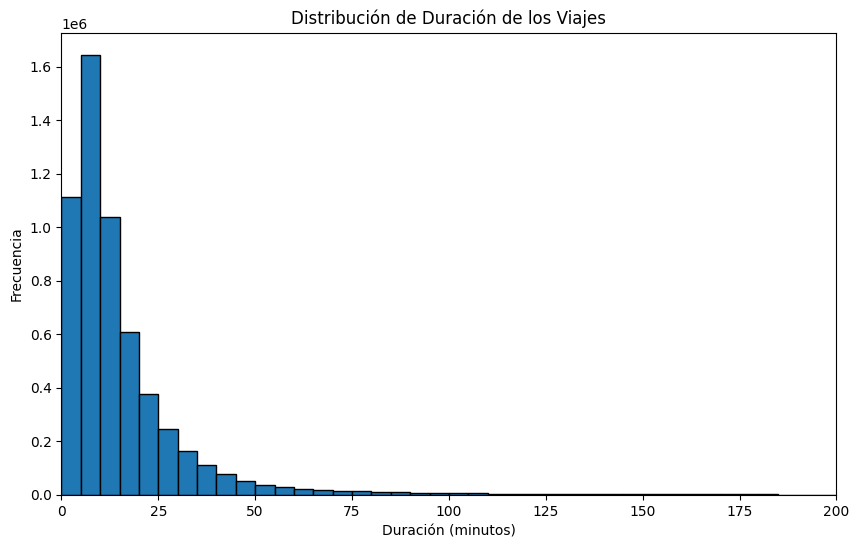

In [10]:
# Convert duration to minutes
duration_minutes = df_rides_filtered['duration'].dt.total_seconds() / 60

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(duration_minutes, bins=range(0, 301, 5), edgecolor='black')  # Bins from 5 minutes to 300 minutes
plt.title('Trip Duration Distribution')
plt.xlabel('Duration(mins)')
plt.ylabel('Frequency')
plt.xlim(0, 200)  # Limit x axis to 300 minutes

plt.show()



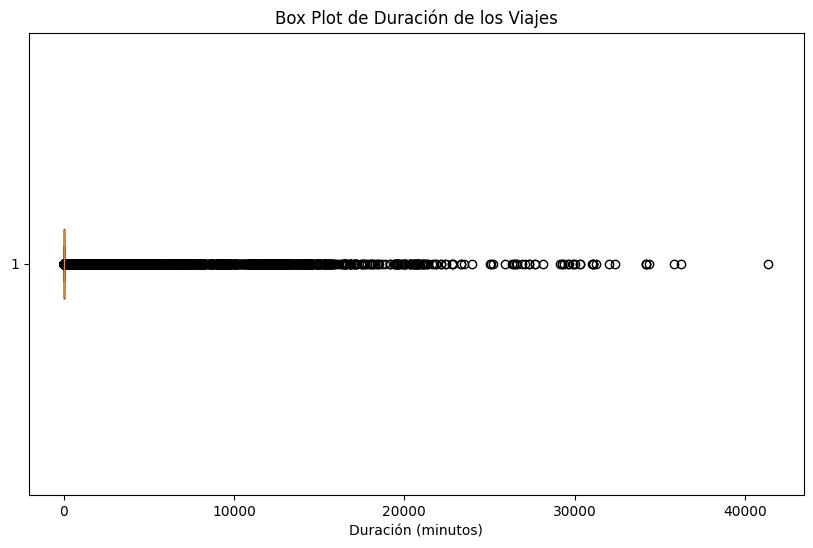

In [11]:
#box plot
plt.figure(figsize=(10, 6))
plt.boxplot(duration_minutes, vert=False) 
plt.title('Rides duration')
plt.xlabel('Duration (min)')

plt.show()


In [93]:
# Quantiles
q1 = duration_minutes.quantile(0.25)
q3 = duration_minutes.quantile(0.75)
iqr = q3 - q1


print(f"1st Quartile (Q1): {q1} minutes")
print(f"3rd Quartile (Q3): {q3} minutes")
print(f"Interquartile Range (IQR): {iqr} minutes")

# Calculate limits to identify extreme values
lower_limit_iqr = max(0, q1 - 1.5 * iqr) # Make sure the lower limit is not negative
upper_limit_iqr = q3 + 1.5 * iqr

print(f"Lower limit for extreme values: {lower_limit_iqr} minutes")
print(f"Upper limit for extreme values: {upper_limit_iqr} minutes")

1st Quartile (Q1): 8.633333333333333 minutes
3rd Quartile (Q3): 18.816666666666666 minutes
Interquartile Range (IQR): 10.183333333333334 minutes
Lower limit for extreme values: 0 minutes
Upper limit for extreme values: 34.09166666666667 minutes


In [94]:
"""A manual cut was made at the lower limit > 3 minutes, understanding that shorter durations
They can be failed or unfinished trips """

# Establish limits
lower_limit = 5.8
upper_limit = 37.4

# Filter dataframe 
df_rides_filtered = df_rides_filtered[
    (duration_minutes >= lower_limit) & (duration_minutes <= upper_limit)
]

/var/folders/9k/8wb8mfgj7ws49746k2fqnp5w0000gp/T/ipykernel_55715/892335373.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rides_filtered = df_rides_filtered[


In [95]:
print(df_rides_filtered['duration'].describe())

count                      3666814
mean     0 days 00:14:28.676408729
std      0 days 00:07:26.448163959
min                0 days 00:05:48
25%                0 days 00:08:36
50%                0 days 00:12:17
75%                0 days 00:18:30
max                0 days 00:37:24
Name: duration, dtype: object


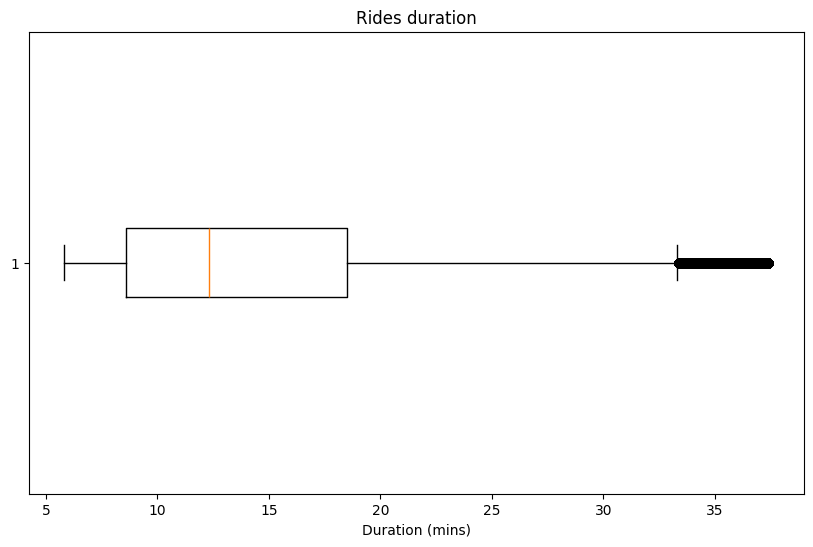

In [96]:
# Convert duration to minutes and round to 1 decimal place
duration_minutes_rounded = (df_rides_filtered['duration'].dt.total_seconds() / 60).round(1)


# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(duration_minutes_rounded, vert=False) 
plt.title('Rides duration')
plt.xlabel('Duration (mins)')

plt.show()


### User Type Count

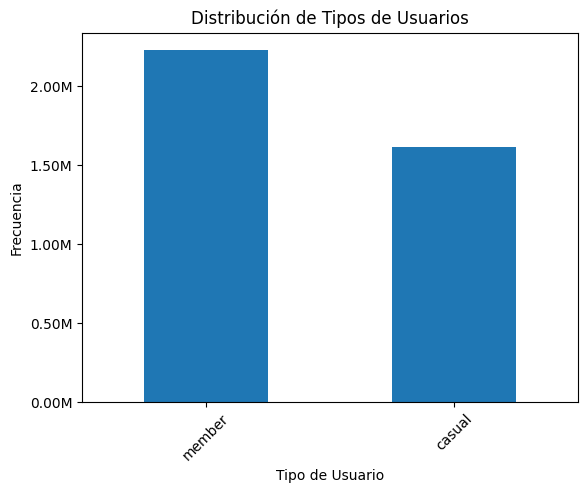

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def millions_formatter(x, pos):
    """Convert numbers to millions format with two decimals."""
    return '{:.2f}M'.format(x / 1e6)

# Count and plot
user_type_counts = df_merged['user_type'].value_counts()
ax = user_type_counts.plot(kind='bar')

# Add titles and tags
plt.title('Distribución de Tipos de Usuarios')
plt.xlabel('Tipo de Usuario')
plt.ylabel('Frecuencia')

# Set custom formatter for y axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(millions_formatter))

plt.xticks(rotation=45)

plt.show()


### Stations count

In [97]:
# JOIN facts with Dim df
df_station_counts_combined = pd.merge(station_counts, df_station, on='station_id', how='left')


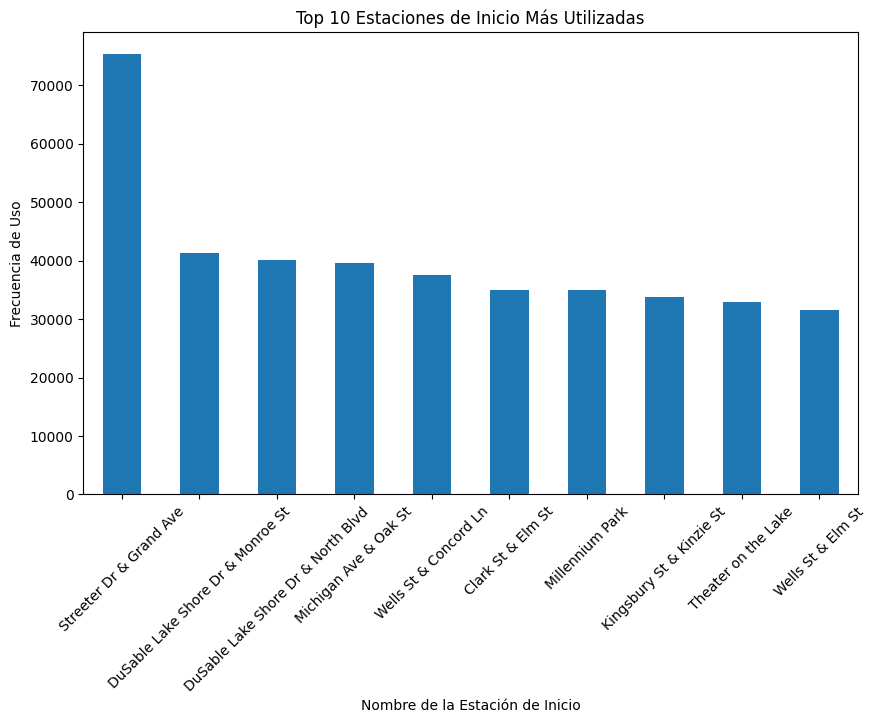

In [35]:
# Top 10 start_station
top_10_start_stations = df_station_counts_combined.nlargest(10, 'start_count')

# Plot
plt.figure(figsize=(10, 6))
top_10_start_stations.set_index('station_name')['start_count'].plot(kind='bar')
plt.title('Top 10 Estaciones de Inicio Más Utilizadas')
plt.xlabel('Nombre de la Estación de Inicio')
plt.ylabel('Frecuencia de Uso')
plt.xticks(rotation=45)
plt.show()


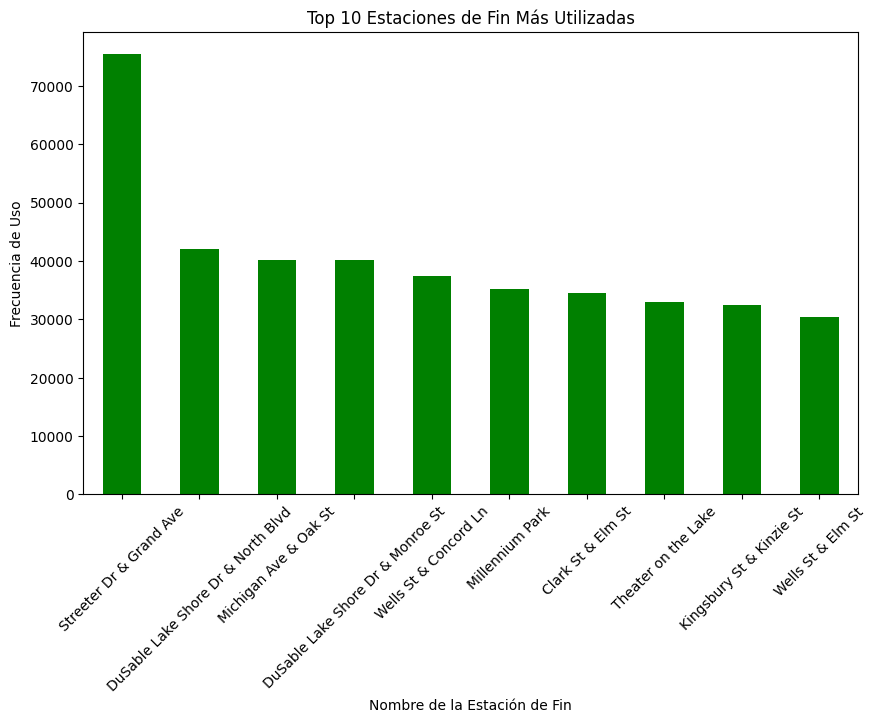

In [36]:
# Top 10 end_stations
top_10_end_stations = df_station_counts_combined.nlargest(10, 'end_count')

# Plot
plt.figure(figsize=(10, 6))
top_10_end_stations.set_index('station_name')['end_count'].plot(kind='bar', color='green')
plt.title('Top 10 Estaciones de Fin Más Utilizadas')
plt.xlabel('Nombre de la Estación de Fin')
plt.ylabel('Frecuencia de Uso')
plt.xticks(rotation=45)
plt.show()


### Distance

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula la distancia del gran círculo entre dos puntos 
    en la tierra especificados por su latitud y longitud en grados.
    """
    # Earth radius in km
    R = 6371.0

    # Converting degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

# Apply function to df
df_rides_filtered['ride_distance'] = df_rides_filtered.apply(
    lambda row: haversine(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']),
    axis=1
)

# Calculate avg distance
average_distance = df_rides_filtered['ride_distance'].mean()
print(f"Rides average distance: {average_distance:.2f} km")


In [78]:
print(df_rides_filtered['ride_distance'].describe())

count   3666814.00
mean          2.60
std           9.02
min           0.50
25%           1.43
50%           2.14
75%           3.31
max        9814.07
Name: ride_distance, dtype: float64


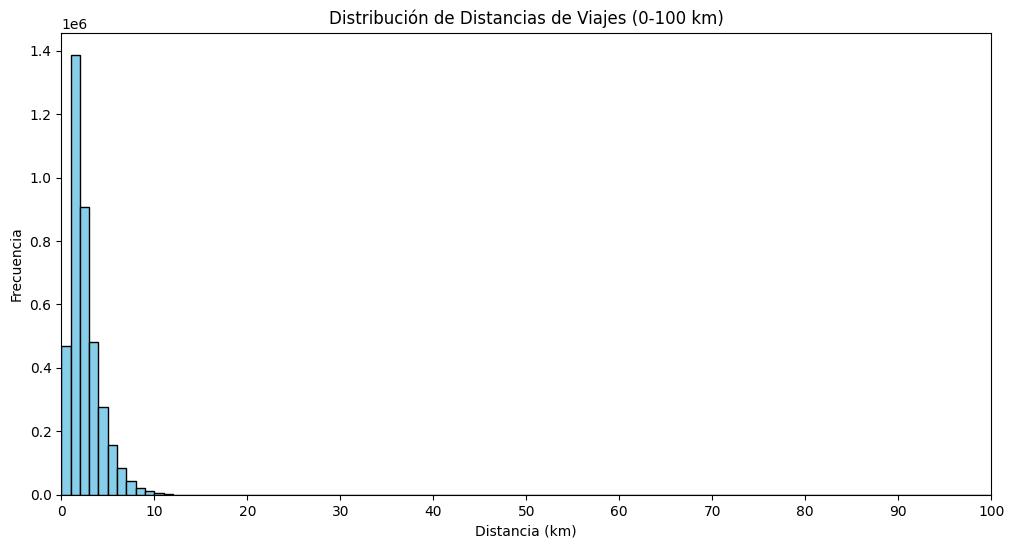

In [50]:
# Plot histogram ride_distance
plt.figure(figsize=(12, 6))
plt.hist(df_rides_filtered['ride_distance'], bins=range(0, 101), edgecolor='black', color='skyblue')
plt.title('Travel Distance Distribution (0-100 km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # Limit x axis to 100 km
plt.xticks(range(0, 101, 10))  # 10km bins
plt.show()


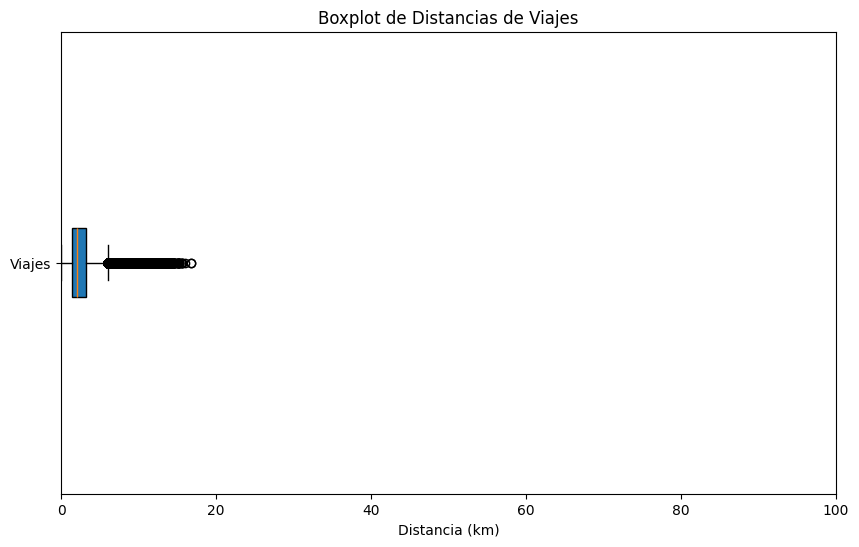

In [58]:
# Make sure 'ride_distance' is a numeric column
df_rides_filtered['ride_distance'] = pd.to_numeric(df_rides_filtered['ride_distance'], errors='coerce')

# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_rides_filtered['ride_distance'].dropna(), vert=False, patch_artist=True)  # Delet NaNs for this boxplot

plt.title('Rides Distance')
plt.xlabel('Distance (km)')
plt.yticks([1], ['Rides'])
plt.xlim(0, 100)

plt.show()


In [69]:
#Manual cut on trips less than 0.5 km
df_rides_filtered = df_rides_filtered[df_rides_filtered['ride_distance'] >= 0.5]

In [101]:
#Calculate the first and third quartiles (Q1 and Q3)
Q1 = df_rides_filtered['ride_distance'].quantile(0.25)
Q3 = df_rides_filtered['ride_distance'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define limits to identify extreme values
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

print(lower_limit, upper_limit)


-1.3900000000000003 6.130000000000001


In [72]:
df_rides_filtered_iqr = df_rides_filtered[
    (df_rides_filtered['ride_distance'] >= lower_limit) &
    (df_rides_filtered['ride_distance'] <= upper_limit)
]

In [74]:
df_rides_filtered_iqr['distance_km'].describe()

count   3513045.00
mean          2.38
std           1.25
min           0.50
25%           1.40
50%           2.06
75%           3.08
max           6.13
Name: distance_km, dtype: float64

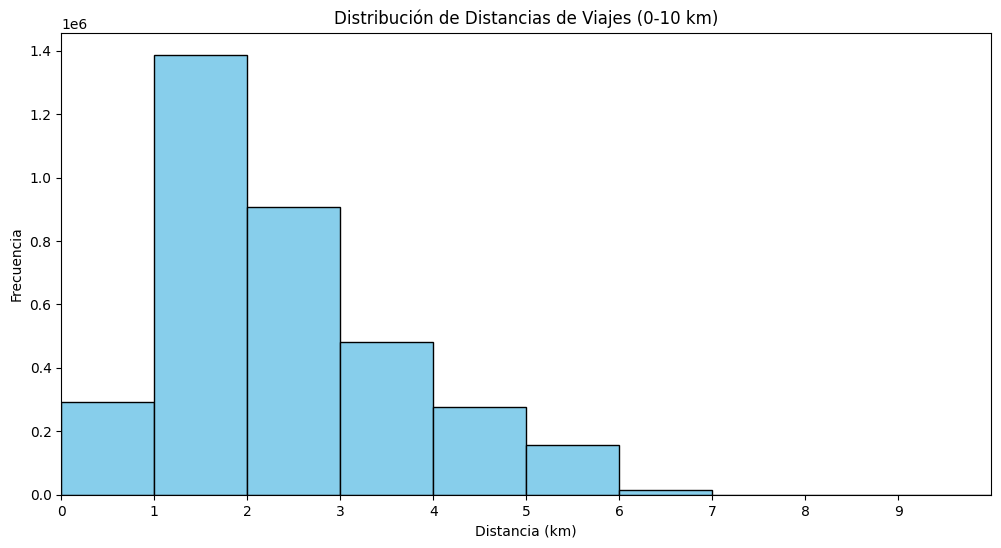

In [83]:
# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(df_rides_filtered_iqr['ride_distance'], bins=range(0, 101), edgecolor='black', color='skyblue')
plt.title('Distribution of Travel Distances (0-10 km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.xlim(0, 10)  # Limit x axis to 100 km
plt.xticks(range(0, 10, 1))  # bins 10km
plt.show()


In [87]:
# Create a separate copy of the DataFrame to avoid SettingWithCopyWarning
df_rides_filtered_iqr = df_rides_filtered_iqr.copy()

# Convert 'ride_distance' to numeric
df_rides_filtered_iqr['ride_distance'] = pd.to_numeric(df_rides_filtered_iqr['ride_distance'], errors='coerce')

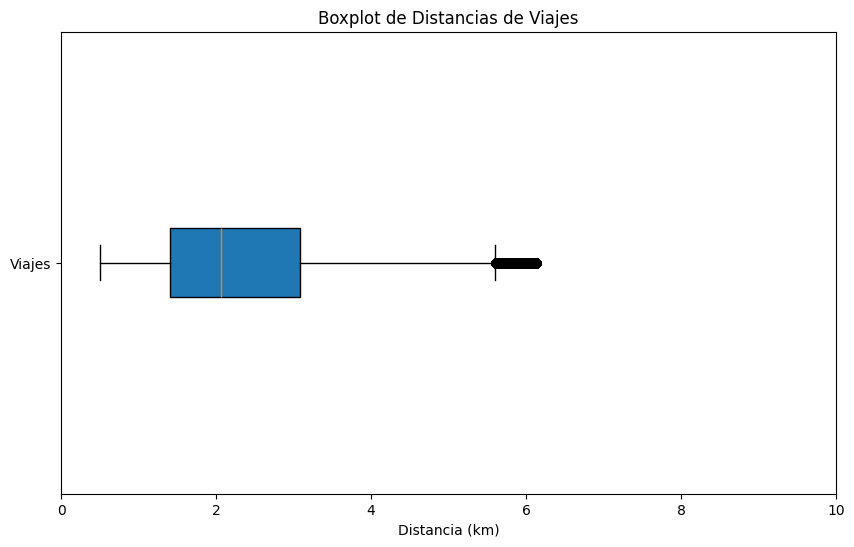

In [88]:
#Create a boxplot of the 'ride_distance' column
plt.figure(figsize=(10, 6))
plt.boxplot(df_rides_filtered_iqr['ride_distance'].dropna(), vert=False, patch_artist=True)  # Delete NaNs for this boxplot

plt.title('Travel distance')
plt.xlabel('Distance (km)')
plt.yticks([1], ['Rides'])
plt.xlim(0, 10)  # Establecer límites para el eje x

plt.show()


# Falta la distancia por tipo de usuario y bike y mover los chart de duration hacia arriba donde corresponden.

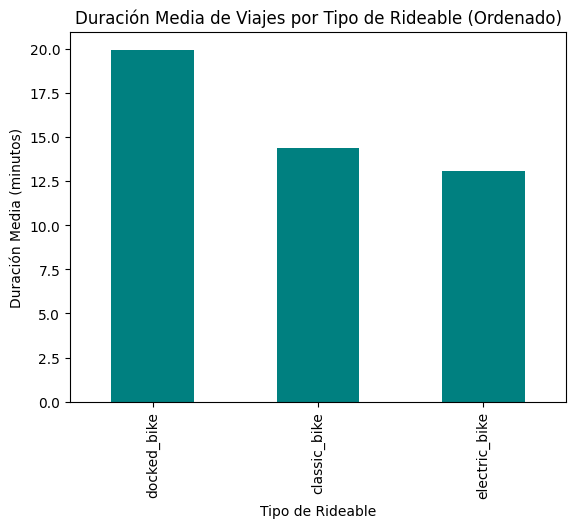

In [90]:
# Fusionar df_rides_filtered_iqr con df_rideable_type en 'rideable_id'
combined_df = pd.merge(df_rides_filtered_iqr, df_rideable_type, on='rideable_id')

# Agrupar por 'rideable_type' y calcular la duración media
average_durations = combined_df.groupby('rideable_type')['duration'].mean()

# Convertir la duración media a minutos
average_durations_minutes = average_durations.dt.total_seconds() / 60

# Ordenar los valores de mayor a menor
average_durations_sorted = average_durations_minutes.sort_values(ascending=False)

# Graficar la duración media por tipo de rideable
average_durations_sorted.plot(kind='bar', color='teal')
plt.title('Duración Media de Viajes por Tipo de Rideable (Ordenado)')
plt.xlabel('Tipo de Rideable')
plt.ylabel('Duración Media (minutos)')
plt.show()


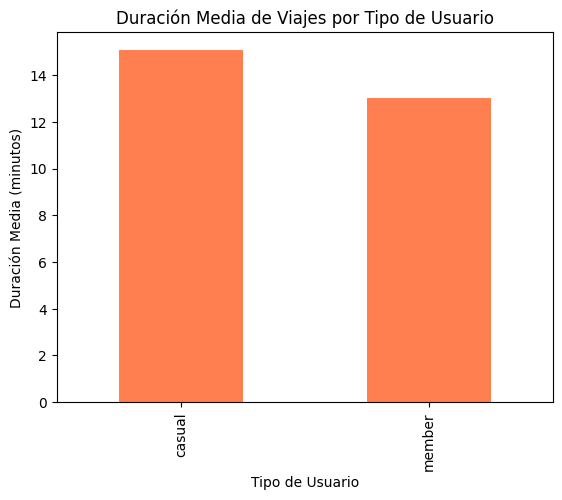

In [91]:
# Fusionar df_rides_filtered_iqr con df_user_type en 'user_type_id'
combined_df = pd.merge(df_rides_filtered_iqr, df_user_type, on='user_type_id')

# Agrupar por 'user_type' y calcular la duración media
average_durations = combined_df.groupby('user_type')['duration'].mean()

# Convertir la duración media a minutos para una mejor interpretación
average_durations_minutes = average_durations.dt.total_seconds() / 60

# Graficar la duración media por tipo de usuario
average_durations_minutes.plot(kind='bar', color='coral')
plt.title('Duración Media de Viajes por Tipo de Usuario')
plt.xlabel('Tipo de Usuario')
plt.ylabel('Duración Media (minutos)')
plt.show()


In [27]:
# connection_string.close()